# In this notebook we want to predict the July18 patterned electrode impedance.

## We consider an equivalent circuit model composed of: an ohmic resistance in series with two parallel branches. One branch, (A) represents processes occuring through/at the mask layer. The other branch (B) represents processes through the gate and extending into the thin film LSC. Branch (B) is a series resistance attributed to current constriction near the gate followed by two parallel branches, one for the R//C behvaior of LSC material at the gate and the other for gerischer behavior extending laterally away from the gate.

## Components of the model are sourced from
1. $R_{\Omega}$: series ohmic resistanc estimated from GDC-10 ionic conductivity and macroscopic sample geometry
2. Branch (A): NoHole sample impedance measurements scaled to patterned electrode geometry
3. Branch (B), $R_c$: series resistance estimated by solving Laplacian in cylindrical coordinates, where we assume the gate is a cylinder of diameter G (gate width) aligned longitudnally with gate length. The gate-cylinder boundary is grounded and a potential is defined at a radius, r2. 
4. Branch (B), $Z_G$: 1-dimensional model of impedance from the Gerischer process extending away from the gate
5. Branch (B), $R_{gate}$: kinetially-limited resistance of LSC film at the gate, estimated by eq. 3.20 of Keita Mizuno's master's thesis, using Adler and McDonald Mixed-Bulk thermodynamic model for ${x_v}^o$, and ${R_O}^o$ extracted from FR-XAS profiles
6. Branch (B), $C_{gate}$: chemical capacitance of LSC film at the gate, estimated by eq. 3.47 of Keita Mizuno's master's thesis, using aforementioned thermo model, Vm = 33.7 $\frac{cm^3}{mol}$, and $c_{fit}=228\frac{kJ}{mol}$ (Table 3-1)

## The circuit we're considering is represented as $Z = R_{\Omega} + \frac{1}{\frac{1}{Z_{NH} x T} + \frac{1}{R_{c}+\frac{1}{\frac{1}{Z_G}+\frac{R_{gate}}{1+j \omega R_{gate} C_{gate}}}}}$

In [40]:
import glob
import sys

import numpy as np
import pandas as pd
from scipy import signal
from scipy.optimize import minimize

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.font_manager as font_manager

from impedance.models.circuits import CustomCircuit
from impedance.visualization import plot_nyquist, plot_bode, plot_residuals
from impedance import preprocessing
from impedance.models.circuits.elements import G

sys.path.insert(0, '..')
import analyze_comsol as an_com
import ImpedanceCorrection as ic
import berthier_20210303 as berthier

%reload_ext autoreload
%autoreload 2

### Read in patterned electrode data

In [41]:
data_dir = '..\EIS Data'
file_str1 = r'\LSC_DPB1_FRXAS_700C_1%_EIS_OCV_before2.par'
file_str10 = r'\LSC_DPB1_FRXAS_700C_10%_EIS_OCV_after.par'
file_str100 = r'\LSC_DPB1_FRXAS_700C_100%_EIS_OCV_before2.par'

f_1, Z_1 = berthier.read_EIS_data(data_dir, file_str1, z_format=preprocessing.readVersaStudio)
f_10, Z_10 = berthier.read_EIS_data(data_dir, file_str10, z_format=preprocessing.readVersaStudio)
f_100, Z_100 = berthier.read_EIS_data(data_dir, file_str100, z_format=preprocessing.readVersaStudio)


# L0 = 1e-1
# Z_1 = ic.subtract_series_L(f_1, Z_1, L0)
# Z_10 = ic.subtract_series_L(f_10, Z_10, L0)
# Z_100 = ic.subtract_series_L(f_100, Z_100, L0)

print(f_1[19], f_1[-1])
print(f_10[20], f_10[-1])
print(f_100[19], f_100[-1])

fs_list = [f_1, f_10, f_100]
Zs_list = [Z_1, Z_10, Z_100]

464.1589 0.02154435
794.3282 0.007943282
359.3814 0.1


More than one peak detected. Returning lowest-frequency values.
More than one peak detected. Returning lowest-frequency values.


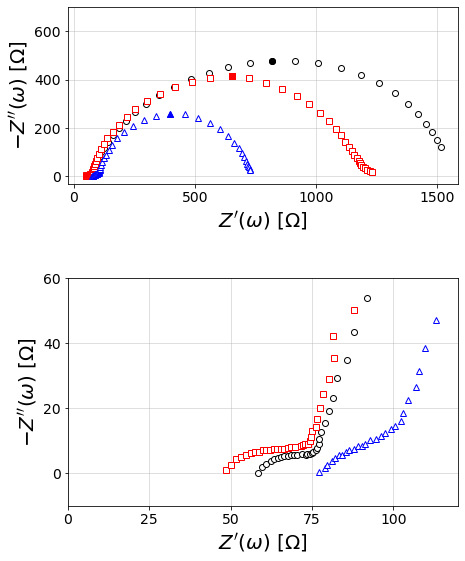

In [42]:
_, axes = plt.subplots(nrows=2, figsize=(7,10))
colors = [(0, 0, 0), (1, 0, 0), (0, 0, 1)]
markers = ['o', 's', '^']

for i, (f, Z) in enumerate(zip(fs_list, Zs_list)):
    f_peak, Z_peak = ic.find_peak_f_Z(f, Z)
    for ax in axes:
        plot_nyquist(ax, Z, c=colors[i], fmt=markers[i], mfc=(1,1,1))
        plot_nyquist(ax, Z_peak, c=colors[i], fmt=markers[i], units='\Omega')

axes[0].set_ylim(-30, 700)
axes[1].set_xlim(0, 120)
axes[1].set_ylim(-10, 60)
plt.show()

In [43]:
for Z in Zs_list:
    print(Z[0].real)

58.32154
48.67418
77.18876


## Read in NoHole sample data, truncated to the same frequency range as the patterned electrode measurements

In [44]:
data_dir = '..\EIS Data'
file_str1 = r'\NoHoleAl2O3_July18_freq_range_1%O2.csv'
file_str10 = r'\NoHoleAl2O3_July18_freq_range_10%O2.csv'
file_str100 = r'\NoHoleAl2O3_July18_freq_range_100%O2.csv'

f_1nh, Z_1nh = berthier.read_EIS_data(data_dir, file_str1, z_format=preprocessing.readCSV)
f_10nh, Z_10nh = berthier.read_EIS_data(data_dir, file_str10, z_format=preprocessing.readCSV)
f_100nh, Z_100nh = berthier.read_EIS_data(data_dir, file_str100, z_format=preprocessing.readCSV)

fs_nh_list = [f_1nh, f_10nh, f_100nh]
Zs_nh_list = [Z_1nh, Z_10nh, Z_100nh]

More than one peak detected. Returning lowest-frequency values.
More than one peak detected. Returning lowest-frequency values.


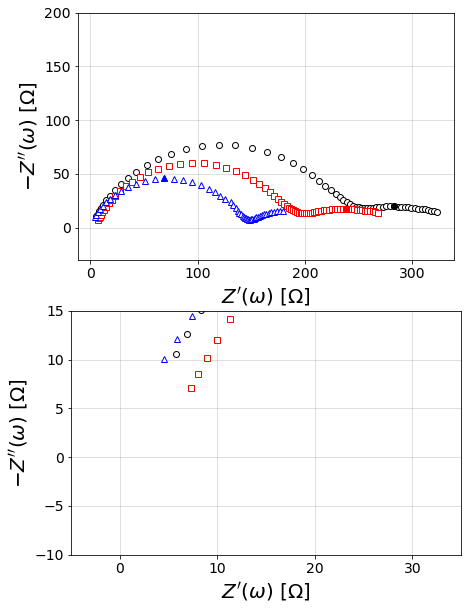

In [45]:
_, axes = plt.subplots(nrows=2, figsize=(7,10))
colors = [(0, 0, 0), (1, 0, 0), (0, 0, 1)]
markers = ['o', 's', '^']

for i, (f, Z) in enumerate(zip(fs_nh_list, Zs_nh_list)):
    f_peak, Z_peak = ic.find_peak_f_Z(f, Z)
    plot_nyquist(axes[0], Z, c=colors[i], fmt=markers[i], mfc=(1,1,1))
    plot_nyquist(axes[1], Z, c=colors[i], fmt=markers[i], mfc=(1,1,1))
    plot_nyquist(axes[0], Z_peak, c=colors[i], fmt=markers[i], units='\Omega')
    plot_nyquist(axes[1], Z_peak, c=colors[i], fmt=markers[i], units='\Omega')


axes[0].set_ylim(-30, 200)
axes[1].set_xlim(-5, 35)
axes[1].set_ylim(-10, 15)
plt.show()

### Defining functions to calculate volume specific capacitance and area specific resistance for predictions down below

In [46]:
MB_delta = np.genfromtxt(r'G:\\My Drive\\UW Research\\fr-XAS July 2018\\Discussions\\Mixed_Bulk_Nonstoich.csv', delimiter=',')
MB_Ao = np.genfromtxt(r'G:\\My Drive\\UW Research\\fr-XAS July 2018\\Discussions\\Mixed_Bulk_Thermo.csv', delimiter=',')

MB_delta = MB_delta[np.argsort(MB_delta[:,0])]
MB_Ao = MB_Ao[np.argsort(MB_Ao[:,0])]

### Use Values interpolated for Ao since it's a larger data set

In [47]:
# Constructing lists of Po2, Ao, delta for both models using data arrays and 
# interpolating for Ao if Po2's don't match exactly
MB_vals = []
for delta in MB_delta:
    try:
        ao = MB_Ao[np.argwhere(np.isclose(MB_Ao[:,0], delta[0]))[0,0]][-1]
#         print(f'Match Po2: {ao[0]:.2f}, Ao: {ao[1]:.3f}, delta: {delta:.4f}')
        MB_vals.append([delta[0], ao, delta[1]])
    except IndexError:
        ao = np.interp(delta[0], MB_Ao[:,0], MB_Ao[:,1])
#         print(f'Interp Po2: {ao[0]:.2f}, Ao: {ao[1]:.3f}, delta: {delta:.4f}')
        MB_vals.append([delta[0], ao, delta[1]])

mb_df = pd.DataFrame(data=np.array(MB_vals), columns=['pO2', 'ao', 'delta'])

In [84]:
dum = [[A_patt, A_NH, A_gate, L_patt, L_NH, L_LSC, w]]
pd.DataFrame(data=np.array(dum), columns=['A_patt', 'A_NH', 'A_gate', 'L_patt', 'L_NH', 'L_LSC', 'W'])

,A_patt,A_NH,A_gate,L_patt,L_NH,L_LSC,W
0,0.122033,1.327323,0.000467,0.000028,0.000045,0.000063,1.04345


In [137]:
# Some geometry calculations
w = 1.04345
A_NH = np.pi * (0.65**2)
L_NH = 450e-7
A_gate = w * 4.478e-4
A_patt = .35**2 - A_gate #0.110 - A_gate  #0.117
L_LSC = 630e-7
L_patt = 280e-7

sig_i_lt = 0.0544
R_ohm = 1 / sig_i_lt * .1 / A_patt
print(R_ohm)
# Correction factor for patterned geometry to NH geometry
geom_corr = A_NH/A_patt*L_patt/L_NH

params_df = pd.DataFrame(data=[-2, -1, 0], columns=['pO2'])
params_df['ao'] = [mb_df.loc[
    np.isclose(mb_df.pO2, pO2, atol=.001), 'ao'].values[0] for pO2 in params_df.pO2.values]
params_df['xvo'] = [mb_df.loc[
    np.isclose(mb_df.pO2, pO2, atol=.001), 'delta'].values[0] / 3 for pO2 in params_df.pO2.values]

params_df['ld'] = [32.801e-4, 17.146e-4, 4.978e-4]
params_df['tg'] = [2.344, 0.9462, 0.1447]

params_df['c_chem'] = berthier.c_chem(params_df.xvo * 3)
params_df['ASR'] = berthier.ASR(params_df.ao, params_df.xvo, params_df.tg)

params_df['Rg'] = [berthier.Rg(row.ao, row.xvo, row.tg, row.ld, w) for _, row in params_df.iterrows()]
params_df['R_gate'] = params_df.ASR / A_gate
params_df['C_gate'] = params_df.c_chem * A_gate * L_LSC

# Estimated current constriction resistance
G = 4.28
r2 = 20 * G
R_con = np.log(2 * r2 / G) / sig_i_lt
R_con

15.063459589381976


67.81028408297678

## $T = \frac{l_{pattern}}{l_{NoHole}}\frac{A_{NoHole}}{A_{pattern}} = 9.77$

# $R_c = \frac{Ln(\frac{2r}{G})}{{\sigma_i}^{lt}}$

# $R_{\Omega} =\frac{1}{{\sigma_i}^{lt}}\frac{1 \, mm}{A_{patt}} = 15 \, {\Omega}$

No handles with labels found to put in legend.


Simulating circuit based on initial parameters
Simulating circuit based on initial parameters
Simulating circuit based on initial parameters


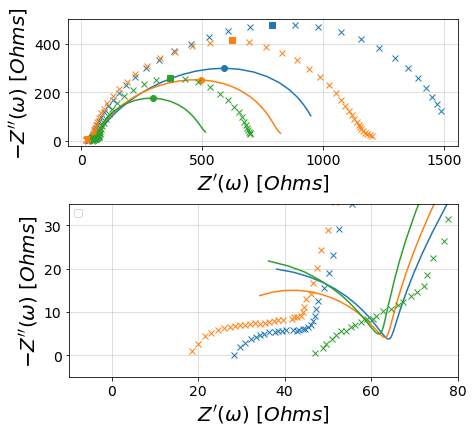

,pO2,$f_p$,"$f_{p,model}$"
0,-2.0,0.464159,0.215444
1,-1.0,1.258925,0.501187
2,0.0,4.641589,2.782559


In [130]:
# Using estimated geometry correction factor
_, axes = plt.subplots(nrows=2, figsize=(7, 7))

Zs_branch_b = []
f_peaks, f_peaks_model = [], []
params_df['Rg'] = [berthier.Rg(row.ao, row.xvo, row.tg, row.ld, w) for _, row in params_df.iterrows()]

for gas, Z_nh  in enumerate(Zs_nh_list):
    Z_branch_b = berthier.predict_branchB(params_df, gas, R_con, fs_nh_list[gas])
    Zs_branch_b.append(Z_branch_b)
    
    Z_model = berthier.branchB_and_nh_parallel(Z_branch_b, Z_nh, geom_corr)
    Z_meas = Zs_list[gas] - R_ohm #Zs_list[gas][0].real
    
    f_peak, Z_peak = ic.find_peak_f_Z(fs_list[gas], Z_meas)
    f_peak_model, Z_peak_model = ic.find_peak_f_Z(fs_list[gas], Z_model)
    f_peaks.append(f_peak)
    f_peaks_model.append(f_peak_model)
#     print(f'Data peak f: {f_peak}, Model peak f: {f_peak_model}')

    for ax in axes:
        plot_nyquist(ax, Z_meas, fmt='x') #, label=f'{10**(gas-2):.2f} bar, Measured')
        c = ax.lines[-1].get_color()
        plot_nyquist(ax, Z_model, color=c, marker='') #, label=f'{10**(gas-2):.2f} bar, Full model')
        # Marking peak frequencies
        
        plot_nyquist(ax, Z_peak, color=c, marker='s')
        plot_nyquist(ax, Z_peak_model, color=c, marker='o')
        

axes[1].set_xlim(-10, 80)
axes[1].set_ylim(-5, 35)
axes[1].legend()
plt.show()

gases = [-2, -1, 0]
pd.DataFrame(data = np.array([gases, f_peaks, f_peaks_model]).T, columns=['pO2', '$f_p$', '$f_{p,model}$'])

Fit geometry factor 13.137890625000018
Fit geometry factor 2.6642578124999923
Fit geometry factor 18.586669921875036


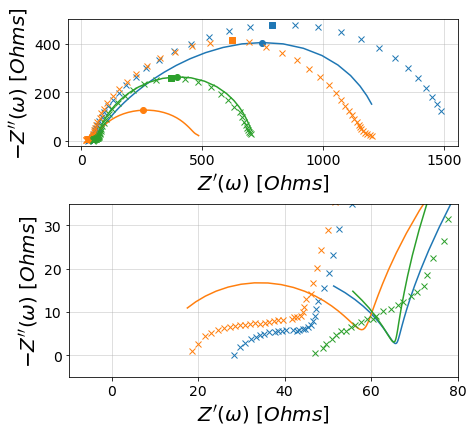

,pO2,$f_p$,"$f_{p,model}$"
0,-2.0,0.464159,0.166810
1,-1.0,1.258925,1.258925
2,0.0,4.641589,2.154435


In [131]:
# Fitting geometry factor to datasets individually
_, axes = plt.subplots(nrows=2, figsize=(7, 7))

f_peaks, f_peaks_model = [], []

for gas, (Z_nh, Z_branch_b) in enumerate(zip(Zs_nh_list, Zs_branch_b)):
    
    Z_meas = Zs_list[gas] - R_ohm
    fit = minimize(berthier.minimize_geom_factor, [6], method='Nelder-Mead',
                   args=(Z_meas, Z_branch_b, Z_nh))
    print(f'Fit geometry factor {fit.x[0]}')
    Z_model = berthier.branchB_and_nh_parallel(Z_branch_b, Z_nh, fit.x[0])
    
    f_peak, Z_peak = ic.find_peak_f_Z(fs_list[gas], Z_meas)
    f_peak_model, Z_peak_model = ic.find_peak_f_Z(fs_list[gas], Z_model)
    f_peaks.append(f_peak)
    f_peaks_model.append(f_peak_model)
    
#     print(f'Data peak f: {f_peak}, Model peak f: {f_peak_model}')
    for ax in axes:
        plot_nyquist(ax, Z_meas, fmt='x', label=f'{10**(gas-2):.2f} bar, Measured')
        c = ax.lines[-1].get_color()
        plot_nyquist(ax, Z_model, color=c, marker='', label=f'{10**(gas-2):.2f} bar, Full model')
        # Marking peak frequencies
        plot_nyquist(ax, Z_peak, color=c, marker='s')
        plot_nyquist(ax, Z_peak_model, color=c, marker='o')
        
axes[1].set_xlim(-10, 80)
axes[1].set_ylim(-5, 35)
plt.show()

gases = [-2, -1, 0]
pd.DataFrame(data = np.array([gases, f_peaks, f_peaks_model]).T, columns=['pO2', '$f_p$', '$f_{p,model}$'])

Fit geometry factor  final_simplex: (array([[25.04919434],
       [25.04912109]]), array([53.80747219, 53.80747224]))
           fun: 53.807472188437416
       message: 'Optimization terminated successfully.'
          nfev: 54
           nit: 27
        status: 0
       success: True
             x: array([25.04919434])


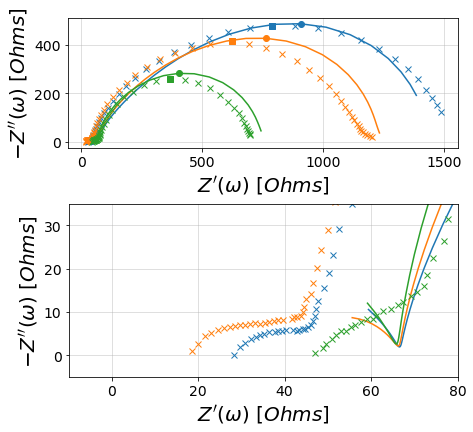

,pO2,$f_p$,"$f_{p,model}$"
0,-2.0,0.464159,0.129155
1,-1.0,1.258925,0.316228
2,0.0,4.641589,2.154435


In [132]:
# Fitting geometry factor to all datasets simultaneously
_, axes = plt.subplots(nrows=2, figsize=(7, 7))

fit = minimize(berthier.minimize_geom_factor_all, [6], method='Nelder-Mead',
               args=(Zs_list, Zs_branch_b, Zs_nh_list))
print(f'Fit geometry factor {fit}')

f_peaks, f_peaks_model = [], []

for gas, (Z_nh, Z_branch_b) in enumerate(zip(Zs_nh_list, Zs_branch_b)):
    Z_meas = Zs_list[gas] - R_ohm
    Z_model = berthier.branchB_and_nh_parallel(Z_branch_b, Z_nh, fit.x[0])
    
    f_peak, Z_peak = ic.find_peak_f_Z(fs_list[gas], Z_meas)
    f_peak_model, Z_peak_model = ic.find_peak_f_Z(fs_list[gas], Z_model)
    f_peaks.append(f_peak)
    f_peaks_model.append(f_peak_model)
#     print(f'Data peak f: {f_peak}, Model peak f: {f_peak_model}')

    for ax in axes:
        plot_nyquist(ax, Z_meas, fmt='x', label=f'{10**(gas-2):.2f} bar, Measured')
        c = ax.lines[-1].get_color()
        plot_nyquist(ax, Z_model, color=c, marker='', label=f'{10**(gas-2):.2f} bar, Full model')
        # Marking peak frequencies
        
        plot_nyquist(ax, Z_peak, color=c, marker='s')
        plot_nyquist(ax, Z_peak_model, color=c, marker='o')
        
axes[1].set_xlim(-10, 80)
axes[1].set_ylim(-5, 35)
plt.show()

gases = [-2, -1, 0]
pd.DataFrame(data = np.array([gases, f_peaks, f_peaks_model]).T, columns=['pO2', '$f_p$', '$f_{p,model}$'])

Simulating circuit based on initial parameters
Simulating circuit based on initial parameters
Simulating circuit based on initial parameters
Fit geometry factor  final_simplex: (array([[9.76875   ],
       [9.76867676]]), array([47.27823156, 47.27823237]))
           fun: 47.27823155539929
       message: 'Optimization terminated successfully.'
          nfev: 36
           nit: 18
        status: 0
       success: True
             x: array([9.76875])
Data peak f: 0.4641589, Model peak f: 0.2782559
Data peak f: 1.258925, Model peak f: 0.6309574
Data peak f: 4.641589, Model peak f: 2.782559


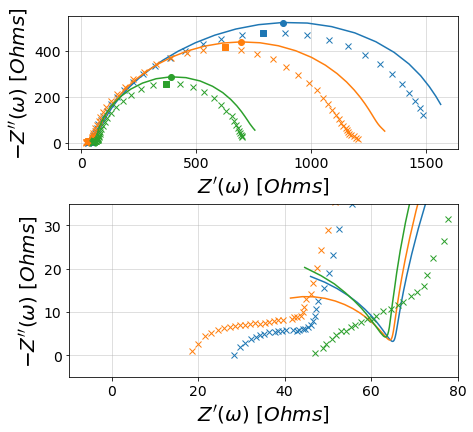

,pO2,ao,xvo,ld,tg,c_chem,ASR,Rg,R_gate,C_gate
0,-2,2.689352,0.020081,0.003280,2.3440,3050.050719,12.159668,3552.736412,26023.516539,0.000090
1,-1,2.088116,0.013104,0.001715,0.9462,2547.283825,5.840587,3264.540328,12499.733913,0.000075
2,0,1.673198,0.007533,0.000498,0.1447,1885.717904,1.244997,2396.854758,2664.480345,0.000056


In [133]:
# Fitting geometry factor to all datasets simultaneously, but with 2 * Rg
_, axes = plt.subplots(nrows=2, figsize=(7, 7))
Zs_branch_b = []

params_df['Rg'] = [berthier.Rg(row.ao, row.xvo, row.tg, row.ld, w) * 2 for _, row in params_df.iterrows()]
for gas, Z_nh  in enumerate(Zs_nh_list):
    Z_branch_b = berthier.predict_branchB(params_df, gas, R_con, fs_nh_list[gas])
    Zs_branch_b.append(Z_branch_b)


fit = minimize(berthier.minimize_geom_factor_all, [6], method='Nelder-Mead',
               args=(Zs_list, Zs_branch_b, Zs_nh_list))
print(f'Fit geometry factor {fit}')

f_peaks, f_peaks_model = [], []

for gas, (Z_nh, Z_branch_b) in enumerate(zip(Zs_nh_list, Zs_branch_b)):
    Z_meas = Zs_list[gas] - R_ohm
    Z_model = berthier.branchB_and_nh_parallel(Z_branch_b, Z_nh, fit.x[0])
    
    f_peak, Z_peak = ic.find_peak_f_Z(fs_list[gas], Z_meas)
    f_peak_model, Z_peak_model = ic.find_peak_f_Z(fs_list[gas], Z_model)
    f_peaks.append(f_peak)
    f_peaks_model.append(f_peak_model)
    print(f'Data peak f: {f_peak}, Model peak f: {f_peak_model}')

    for ax in axes:
        plot_nyquist(ax, Z_meas, fmt='x', label=f'{10**(gas-2):.2f} bar, Measured')
        c = ax.lines[-1].get_color()
        plot_nyquist(ax, Z_model, color=c, marker='', label=f'{10**(gas-2):.2f} bar, Full model')
        # Marking peak frequencies
        
        plot_nyquist(ax, Z_peak, color=c, marker='s')
        plot_nyquist(ax, Z_peak_model, color=c, marker='o')
        
axes[1].set_xlim(-10, 80)
axes[1].set_ylim(-5, 35)
plt.show()

gases = [-2, -1, 0]
pd.DataFrame(data = np.array([gases, f_peaks, f_peaks_model]).T, columns=['pO2', '$f_p$', '$f_{p,model}$'])
params_df

Simulating circuit based on initial parameters
Simulating circuit based on initial parameters
Simulating circuit based on initial parameters
Data peak f: 0.4641589, Model peak f: 0.3593814
Data peak f: 1.258925, Model peak f: 0.7943282
Data peak f: 4.641589, Model peak f: 3.593814


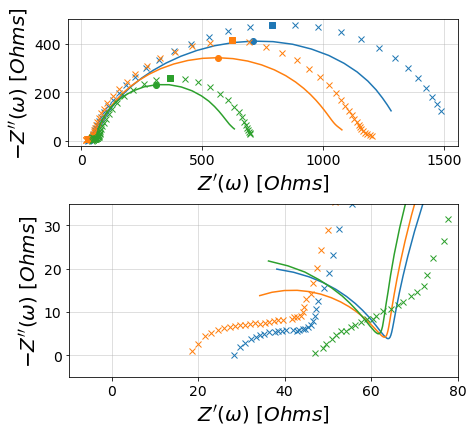

,pO2,$f_p$,"$f_{p,model}$"
0,-2.0,0.464159,0.359381
1,-1.0,1.258925,0.794328
2,0.0,4.641589,3.593814


In [134]:
# Using estimated geometry factor , but with 2 * Rg
_, axes = plt.subplots(nrows=2, figsize=(7, 7))
Zs_branch_b = []

params_df['Rg'] = [berthier.Rg(row.ao, row.xvo, row.tg, row.ld, w) * 2 for _, row in params_df.iterrows()]
for gas, Z_nh  in enumerate(Zs_nh_list):
    Z_branch_b = berthier.predict_branchB(params_df, gas, R_con, fs_nh_list[gas])
    Zs_branch_b.append(Z_branch_b)


# fit = minimize(berthier.minimize_geom_factor_all, [6], method='Nelder-Mead',
#                args=(Zs_list, Zs_branch_b, Zs_nh_list))
# print(f'Fit geometry factor {fit}')

f_peaks, f_peaks_model = [], []

for gas, (Z_nh, Z_branch_b) in enumerate(zip(Zs_nh_list, Zs_branch_b)):
    Z_meas = Zs_list[gas] - R_ohm
    Z_model = berthier.branchB_and_nh_parallel(Z_branch_b, Z_nh, geom_corr)
    
    f_peak, Z_peak = ic.find_peak_f_Z(fs_list[gas], Z_meas)
    f_peak_model, Z_peak_model = ic.find_peak_f_Z(fs_list[gas], Z_model)
    f_peaks.append(f_peak)
    f_peaks_model.append(f_peak_model)
    print(f'Data peak f: {f_peak}, Model peak f: {f_peak_model}')

    for ax in axes:
        plot_nyquist(ax, Z_meas, fmt='x', label=f'{10**(gas-2):.2f} bar, Measured')
        c = ax.lines[-1].get_color()
        plot_nyquist(ax, Z_model, color=c, marker='', label=f'{10**(gas-2):.2f} bar, Full model')
        # Marking peak frequencies
        
        plot_nyquist(ax, Z_peak, color=c, marker='s')
        plot_nyquist(ax, Z_peak_model, color=c, marker='o')
        
axes[1].set_xlim(-10, 80)
axes[1].set_ylim(-5, 35)
plt.show()

gases = [-2, -1, 0]
pd.DataFrame(data = np.array([gases, f_peaks, f_peaks_model]).T, columns=['pO2', '$f_p$', '$f_{p,model}$'])

# Scratch

In [14]:
com_0_01 = pd.read_csv(filepath_or_buffer='../EIS Data/G-2_14_f-MemasuredEIS_MB_LT_Ohmic_pO2-0_01.csv', skiprows=4)

In [15]:
com_0_01.drop(labels = ['Ao', 'xvo', 'ld', 'tg', 'C_mask', 'sig_i_mask (S/m)'], axis=1, inplace=True)

In [16]:
plt_df = com_0_01.loc[:, com_0_01.columns.str.startswith('Plt (K)')].copy()
ohm_df = com_0_01.loc[:, com_0_01.columns.str.startswith('Ohmic')].copy()

In [17]:
ohm_df['f'] = com_0_01['% f']
plt_df['f'] = com_0_01['% f']

In [18]:
np.sqrt((2*(2.401*.63)**2))/4.28

0.49980884599355474

In [19]:
np.sqrt((2*67.254**2)) *.63

59.920256922019284

In [20]:
np.sqrt(2*(48.038*.63)**2)/4.28

9.999923924963925

In [22]:
np.sqrt(2*67.254**2)/4.28

22.222317505570125

In [23]:
(20 - .5)*2

39.0

In [25]:
sig_i_lt = 0.0544
G = 4.28
rs = np.linspace(G/2, 20*G, num=40)
Rohms = np.log(2*rs/G)/sig_i_lt
df= pd.DataFrame(data= rs, columns=['radius'])
df['Rohm'] = Rohms
df['Rohm_diff'] = df.Rohm.diff()
df['R_err'] = df.Rohm_diff / df.Rohm
df['r'] = df.radius/G
df

,radius,Rohm,Rohm_diff,R_err,r
0,2.14,0.000000,NaN,NaN,0.5
1,4.28,12.741676,12.741676,1.000000,1.0
2,6.42,20.195079,7.453403,0.369070,1.5
3,8.56,25.483352,5.288273,0.207519,2.0
4,10.70,29.585256,4.101904,0.138647,2.5
5,12.84,32.936755,3.351499,0.101756,3.0
6,14.98,35.770407,2.833652,0.079218,3.5
7,17.12,38.225028,2.454621,0.064215,4.0
8,19.26,40.390158,2.165129,0.053605,4.5
9,21.40,42.326932,1.936774,0.045757,5.0
